In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_score

In [108]:
store_data = pd.read_csv(r'C:\Data Analysis - Files\Project 5 - Superstore\Sample-Superstore.csv', sep=',', encoding='latin1', on_bad_lines='skip')
store_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [109]:
## Monetary (amount of money spent), Frequency (how frequently the customer bought something) 
# Recency (how many days has passed from today to their last purchase).

store_data_Monetary = store_data.groupby('Customer ID', as_index=False) ['Sales'].sum()

store_data_Monetary.head()

,Customer ID,Sales
0,AA-10315,5563.560
1,AA-10375,1056.390
2,AA-10480,1790.512
3,AA-10645,5086.935
4,AB-10015,886.156


In [110]:
store_data_Frequency = store_data.groupby('Customer ID', as_index=False) ['Order ID'].count()
store_data_Frequency.head()

,Customer ID,Order ID
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6


In [111]:
# change date time type

store_data['Order Date'] = pd.to_datetime(store_data['Order Date'])

# get most recent order date
store_data_Recency = store_data.groupby('Customer ID', as_index=False) ['Order Date'].max()

# get todays date

today = pd.to_datetime('2017-12-30')

print (today)

# days since last purchase

store_data_Recency['Recency'] = (today - store_data_Recency['Order Date']).dt.days

store_data_Recency.head()

2017-12-30 00:00:00


,Customer ID,Order Date,Recency
0,AA-10315,2017-06-29,184
1,AA-10375,2017-12-11,19
2,AA-10480,2017-04-15,259
3,AA-10645,2017-11-05,55
4,AB-10015,2016-11-10,415


In [112]:
# Merge the first two DataFrames
merged_df = pd.merge(store_data_Monetary, store_data_Frequency, how='left', on='Customer ID')

# Merge the result with the third DataFrame
New_df = pd.merge(merged_df, store_data_Recency, how='left', on='Customer ID')

New_df = New_df.rename (columns={'Sales': 'Amount','Order ID': 'Frequency'})

New_df = New_df.drop(columns=['Order Date'])

New_df.head()

,Customer ID,Amount,Frequency,Recency
0,AA-10315,5563.560,11,184
1,AA-10375,1056.390,15,19
2,AA-10480,1790.512,12,259
3,AA-10645,5086.935,18,55
4,AB-10015,886.156,6,415


<Axes: >

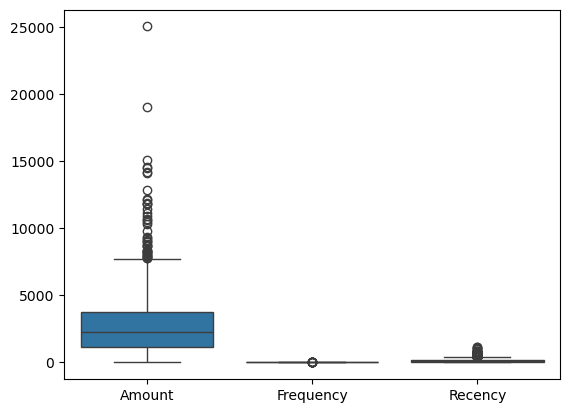

In [113]:
sns.boxplot(data=New_df)

In [114]:
# Function to remove outliers based on IQR
def remove_outliers(New_df):
    # Loop over each column to remove outliers based on IQR
    for column in New_df.columns:
        # Check if the column contains numeric data and is not 'customer_ID'
        if pd.api.types.is_numeric_dtype(New_df[column]) and column != 'customer_ID':
            # Calculate Q1 (25th percentile) and Q3 (75th percentile)
            Q1 = New_df[column].quantile(0.25)
            Q3 = New_df[column].quantile(0.75)
            
            # Calculate the IQR
            IQR = Q3 - Q1
            
            # Define the lower and upper bounds for outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Filter the rows where the column values are within the bounds
            New_df = New_df[(New_df[column] >= lower_bound) & (New_df[column] <= upper_bound)]
    
    return New_df

# Remove outliers
cleaned_New_df = remove_outliers(New_df)

# Show the cleaned data
print("Cleaned Data (Outliers removed):")
print(cleaned_New_df)
cleaned_New_df.info()

Cleaned Data (Outliers removed):
    Customer ID    Amount  Frequency  Recency
0      AA-10315  5563.560         11      184
1      AA-10375  1056.390         15       19
2      AA-10480  1790.512         12      259
3      AA-10645  5086.935         18       55
4      AB-10015   886.156          6      415
..          ...       ...        ...      ...
784    VS-21820  1055.981          8      221
786    VW-21775  6134.038         18       28
789    YC-21895  5454.350          8        4
790    YS-21880  6720.444         12        9
792    ZD-21925  1493.944          9      202

[663 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 663 entries, 0 to 792
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  663 non-null    object 
 1   Amount       663 non-null    float64
 2   Frequency    663 non-null    int64  
 3   Recency      663 non-null    int64  
dtypes: float64(1), int64(2), object(1)


<Axes: >

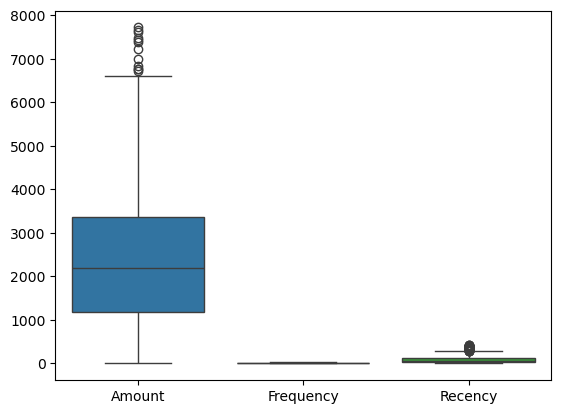

In [115]:
sns.boxplot(data=cleaned_New_df)

In [116]:
from sklearn.preprocessing import StandardScaler

# Assuming cleaned_New_df is already defined and contains the relevant columns

# Selecting the numeric columns (Amount, Frequency, Recency) and excluding 'customer_ID'
rfm_df = cleaned_New_df[['Amount', 'Frequency', 'Recency']]

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
rfm_df_scaled = scaler.fit_transform(rfm_df)

# Convert the scaled data back to a DataFrame and assign the column names
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=['Amount', 'Frequency', 'Recency'])

# Add the 'customer_ID' back to the scaled DataFrame by ensuring matching indices
#rfm_df_scaled['Customer ID'] = cleaned_New_df['Customer ID'].values

# Display the scaled data with customer_ID included
print(rfm_df_scaled.head())
rfm_df_scaled.info()

     Amount  Frequency   Recency
0  1.841594  -0.231602  0.826249
1 -0.851013   0.535200 -0.811889
2 -0.412445  -0.039901  1.570857
3  1.556856   1.110301 -0.454477
4 -0.952712  -1.190104  3.119642
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Amount     663 non-null    float64
 1   Frequency  663 non-null    float64
 2   Recency    663 non-null    float64
dtypes: float64(3)
memory usage: 15.7 KB


In [117]:
rfm_df_scaled.shape # This should output something like (n_samples, n_features)
print(rfm_df_scaled.isnull().sum())
#rfm_df_scaled = rfm_df_scaled.fillna(0)  # Fill missing values with 0

Amount       0
Frequency    0
Recency      0
dtype: int64


In [118]:
# k-means with some arbitrary k
# KMeans clustering with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)

# Fit the model on the scaled data
kmeans.fit(rfm_df_scaled)

# Output cluster centers and labels
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)

Cluster centers: [[ 1.7408648   0.97055701 -0.25934766]
 [-0.69134632 -0.77422509 -0.34662138]
 [ 0.17115536  0.6396812  -0.41095304]
 [-0.53476221 -0.4996103   1.92566664]]
Labels: [0 2 3 0 3 1 2 1 1 3 0 2 3 0 2 3 3 1 1 1 2 2 1 0 1 2 2 1 0 3 1 0 0 0 1 1 1
 0 2 1 1 1 0 0 1 2 1 2 3 1 1 1 2 1 2 1 1 1 0 2 0 2 3 2 1 1 1 3 2 1 3 1 1 2
 1 1 1 2 1 1 0 2 1 3 1 2 2 1 1 2 1 2 1 2 2 1 2 3 3 3 1 2 3 3 0 3 2 3 2 1 2
 2 0 1 0 2 2 1 2 2 1 1 1 3 1 3 3 2 2 2 1 1 1 1 1 1 3 0 0 0 1 1 1 1 1 2 3 2
 2 1 0 2 3 2 1 2 3 2 3 0 2 2 0 3 3 2 1 1 2 1 1 1 0 2 1 0 1 2 1 0 2 2 2 2 1
 2 1 0 2 3 1 1 2 2 3 0 2 2 1 2 1 0 1 3 1 2 2 2 2 2 1 1 2 1 1 2 1 3 3 1 2 1
 3 1 1 1 1 2 1 1 1 0 1 3 1 0 2 2 3 1 0 3 0 2 2 2 2 2 3 2 2 2 0 1 2 2 2 3 1
 0 2 2 1 2 0 1 1 0 1 1 2 1 2 1 2 2 1 1 0 3 1 1 0 1 1 0 3 3 0 2 1 1 1 1 2 1
 1 1 3 3 0 1 2 3 2 2 2 0 0 1 3 1 1 1 3 0 3 2 2 0 0 2 2 1 1 1 2 2 2 1 1 1 0
 2 2 1 3 2 2 2 1 1 1 1 2 0 1 1 2 3 1 2 1 3 1 1 1 3 2 2 2 0 2 0 0 2 0 1 2 1
 2 3 3 0 2 1 0 0 0 1 2 3 1 2 1 2 3 3 3 3 1 1 2 0 1 2 2 2 1 1 2 2 2 3

c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [119]:
# Assign labels to each data point
label_list = kmeans.labels_

# Count the occurrences of each label (cluster)
label_count = Counter(label_list)

# Sort the label count by the cluster label
sorted_label_count = sorted(label_count.items())

# Display the sorted label count
print(sorted_label_count)


[(np.int32(0), 107), (np.int32(1), 244), (np.int32(2), 208), (np.int32(3), 104)]


c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: User

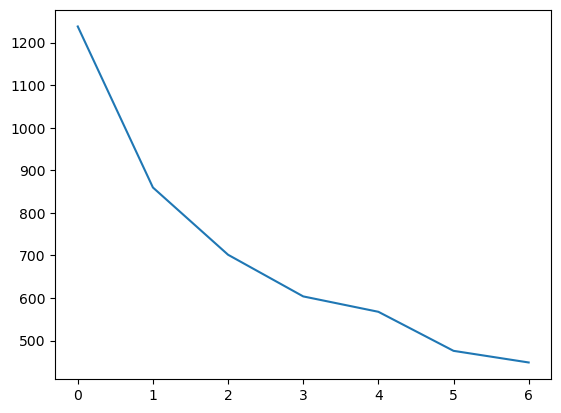

In [120]:
# Elbow-curve /SSD # in order to decide Which value of K is better
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)

In [121]:
# Silhouette analysis
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:

    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.34127785935046806
For n_clusters=3, the silhouette score is 0.36391330758498136
For n_clusters=4, the silhouette score is 0.31991216682124246
For n_clusters=5, the silhouette score is 0.3355570272224749
For n_clusters=6, the silhouette score is 0.2769508155273849
For n_clusters=7, the silhouette score is 0.28369715604716766
For n_clusters=8, the silhouette score is 0.28206857551050535


c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: User

In [124]:
# best K value is 3
kmeans = KMeans(n_clusters=3, max_iter=100)

# Fit the model on the scaled data
kmeans.fit(rfm_df_scaled)

# Output cluster centers and labels
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)

Cluster centers: [[ 0.90500522  0.87141301 -0.35779223]
 [-0.60631842 -0.59112094 -0.36288409]
 [-0.52098855 -0.48117419  1.89436372]]
Labels: [0 1 2 0 2 1 1 1 1 2 0 0 2 0 0 2 2 1 1 1 0 0 1 0 1 0 1 1 0 2 1 0 0 0 1 1 1
 0 0 1 1 1 0 0 1 0 1 0 2 1 1 1 0 1 0 1 1 1 0 0 0 0 2 0 1 1 1 2 0 1 2 1 1 0
 1 1 1 1 1 1 0 1 1 2 1 1 1 1 1 0 1 0 1 0 0 1 0 2 2 2 1 0 2 2 0 2 0 2 0 1 0
 1 0 1 0 0 1 1 1 1 1 1 1 2 1 2 2 1 0 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 0 2 0
 0 1 0 0 2 0 1 1 2 1 2 0 0 0 0 2 2 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1
 0 1 0 0 2 1 1 1 1 2 0 0 0 1 0 1 0 1 2 1 0 0 0 0 1 1 1 1 1 1 0 1 2 2 1 0 1
 2 1 1 1 1 0 1 1 1 0 1 2 1 0 0 0 2 1 0 2 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 2 1
 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 2 1 1 0 1 1 0 2 2 0 0 1 1 1 1 0 1
 1 1 2 2 0 1 0 2 0 1 1 0 0 1 2 1 1 1 2 0 2 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0
 0 0 1 2 1 0 1 1 1 1 1 0 0 1 1 1 2 1 0 1 2 1 1 1 2 1 0 0 0 0 0 0 0 0 1 0 1
 0 2 2 0 0 1 0 0 0 1 0 2 1 0 1 0 2 2 2 2 1 1 0 0 1 0 0 1 1 1 0 0 1 2 0 2 0
 1 0 2 1 0 0 2 0 0 2 0 1 1 1 1 0

c:\Users\Karan\anaconda3\envs\threeten\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [125]:
# assign the label
rfm_df['Cluster_Id'] = kmeans.labels_
rfm_df.head()

,Amount,Frequency,Recency,Cluster_Id
0,5563.560,11,184,0
1,1056.390,15,19,1
2,1790.512,12,259,2
3,5086.935,18,55,0
4,886.156,6,415,2


<Axes: xlabel='Cluster_Id', ylabel='Amount'>

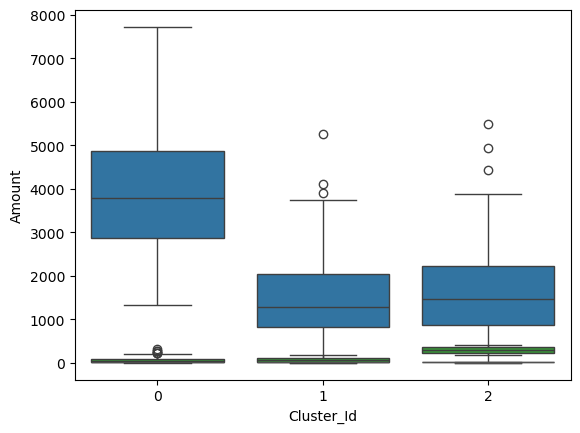

In [126]:
# Box plot to visualize Cluster Id vs Amount
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm_df)

# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm_df)

# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm_df)

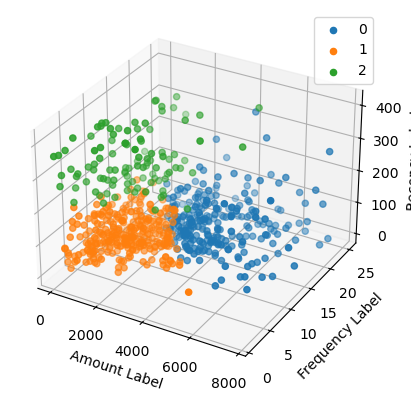

In [127]:
from mpl_toolkits.mplot3d import Axes3D
# Create a figure for the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Loop through each group and plot the corresponding data
for group in rfm_df['Cluster_Id'].unique():
    group_data = rfm_df[rfm_df['Cluster_Id'] == group]
    ax.scatter(group_data['Amount'], group_data['Frequency'], group_data['Recency'], label=group)

# Label the axes
ax.set_xlabel('Amount Label')
ax.set_ylabel('Frequency Label')
ax.set_zlabel('Recency Label')

# Add a legend
ax.legend()

# Show the plot
plt.show()